**1. 데이터 준비**

- 코랩에서 구동해야 했기에 데이터를 다운로드 받고 구글 드라이브에 다시 업로드해서 구글 드라이브 경로로 진행
- 데이터 개수 98401

**2. 데이터 전처리**

- 데이터 분할
- 데이터 개수 98379
- 노드와 개수가 비슷해서 데이터 개수를 줄이지 않고 그냥 진행

**3. 모델 설계**

- LSTM은 셀 상태를 유지하여 자연어 처리에서 긴 문맥 정보를 잘 반영
- 에포크를 늘려도 10 에포크 이전에 과대적합이 일어나서 성능향상을 기대하기 어려움

**4. 모델 훈련**

**5. 인퍼런스 모델 구현 및 모델 테스트**

- 같은 단어의 반복
- 실제와 예측의 단어가 하나도 맞지 않은 것으로 보아 훈련이 제대로 되지 않음

**6. 모델 성능 평가**

# 1. 데이터 준비

In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
import nltk
from bs4 import BeautifulSoup

# NLTK 자원 다운로드
nltk.download('stopwords')
nltk.download('punkt')

# 데이터 로드
file_path = "/content/drive/MyDrive/news_summary_more.csv"
df = pd.read_csv(file_path)

# 데이터 확인
print("데이터 크기:", df.shape)
print("컬럼명:", df.columns.tolist())
print("Null 값 개수:", df.isnull().sum())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


데이터 크기: (98401, 2)
컬럼명: ['headlines', 'text']
Null 값 개수: headlines    0
text         0
dtype: int64


# 2. 데이터 전처리

In [ ]:
# 1. 중복 샘플 제거
df = df.drop_duplicates()

# 2. Null 값이 있는 행 제거
df = df.dropna()

print("전처리 후 데이터 크기:", df.shape)

# 3. 불용어 설정 (영어 불용어 사용)
stop_words = set(stopwords.words('english'))

# 4. 텍스트 전처리 함수 정의
def preprocess_text(text):
    # HTML 태그 제거
    text = BeautifulSoup(text, "html.parser").get_text()

    # 소문자화
    text = text.lower()

    # 괄호로 닫힌 문자열 제거 (...)
    text = re.sub(r'\([^)]*\)', '', text)

    # 쌍따옴표 제거
    text = text.replace('"', '')

    # 약어 정규화
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", "", text)  # 소유격 제거
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)

    # m이 3개 이상이면 2개로 변경
    text = re.sub(r'm{3,}', 'mm', text)

    # 여러 공백을 하나로 변환
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# 5. 텍스트에서 불용어 제거하는 함수
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# 6. 전체 text 컬럼 전처리
df['cleaned_text'] = df['text'].map(preprocess_text)
df['cleaned_text'] = df['cleaned_text'].map(remove_stopwords)

# 7. 헤드라인 전처리 (불용어 제거하지 않음)
df['cleaned_headline'] = df['headlines'].map(preprocess_text)

# 전처리 결과 확인
print("\n원본 텍스트 예시:")
print(df['text'].iloc[0][:200])
print("\n전처리된 텍스트 예시:")
print(df['cleaned_text'].iloc[0][:200])
print("\n원본 헤드라인 예시:")
print(df['headlines'].iloc[0])
print("\n전처리된 헤드라인 예시:")
print(df['cleaned_headline'].iloc[0])

전처리 후 데이터 크기: (98379, 2)

원본 텍스트 예시:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and 

전처리된 텍스트 예시:
saurav kant alumnus upgrad iiit b pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition da

원본 헤드라인 예시:
upGrad learner switches to career in ML & Al with 90% salary hike

전처리된 헤드라인 예시:
upgrad learner switches to career in ml al with salary hike


In [ ]:
# 훈련, 검증, 테스트 셋 분리
train_df, test_df = train_test_split(df, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

# 텍스트 및 헤드라인 데이터 추출
train_texts = train_df['cleaned_text'].values
train_headlines = train_df['cleaned_headline'].values

val_texts = val_df['cleaned_text'].values
val_headlines = val_df['cleaned_headline'].values

test_texts = test_df['cleaned_text'].values
test_headlines = test_df['cleaned_headline'].values

# Tokenizer 구성 (텍스트용)
text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(train_texts)
text_vocab_size = len(text_tokenizer.word_index) + 1

# Tokenizer 구성 (헤드라인용)
headline_tokenizer = Tokenizer()
headline_tokenizer.fit_on_texts(train_headlines)
headline_vocab_size = len(headline_tokenizer.word_index) + 1

# 시퀀스 변환 및 패딩
# 텍스트 시퀀스
train_text_seqs = text_tokenizer.texts_to_sequences(train_texts)
val_text_seqs = text_tokenizer.texts_to_sequences(val_texts)
test_text_seqs = text_tokenizer.texts_to_sequences(test_texts)

# 헤드라인 시퀀스 (시작 및 종료 토큰 추가)
train_headline_seqs = headline_tokenizer.texts_to_sequences(train_headlines)
val_headline_seqs = headline_tokenizer.texts_to_sequences(val_headlines)
test_headline_seqs = headline_tokenizer.texts_to_sequences(test_headlines)

# 시퀀스 길이 확인
max_text_len = max([len(seq) for seq in train_text_seqs])
max_headline_len = max([len(seq) for seq in train_headline_seqs])

# 시퀀스 길이 제한 (너무 긴 경우 모델 학습이 어려울 수 있음)
max_text_len = min(max_text_len, 500)
max_headline_len = min(max_headline_len, 50)

# 패딩 적용
train_text_padded = pad_sequences(train_text_seqs, maxlen=max_text_len, padding='post')
val_text_padded = pad_sequences(val_text_seqs, maxlen=max_text_len, padding='post')
test_text_padded = pad_sequences(test_text_seqs, maxlen=max_text_len, padding='post')

train_headline_padded = pad_sequences(train_headline_seqs, maxlen=max_headline_len, padding='post')
val_headline_padded = pad_sequences(val_headline_seqs, maxlen=max_headline_len, padding='post')
test_headline_padded = pad_sequences(test_headline_seqs, maxlen=max_headline_len, padding='post')

# 디코더 입력 및 타겟 생성 (teacher forcing)
# 디코더 입력: <start> + 헤드라인
# 디코더 타겟: 헤드라인 + <end>

# <start>와 <end> 토큰 정의
start_token = headline_vocab_size
end_token = headline_vocab_size + 1
headline_vocab_size += 2  # vocab_size 업데이트

# 디코더 입력용 시퀀스 생성
decoder_input_train = np.zeros_like(train_headline_padded)
decoder_input_val = np.zeros_like(val_headline_padded)
decoder_input_test = np.zeros_like(test_headline_padded)

# <start> 토큰 추가 및 shift
for i in range(len(decoder_input_train)):
    decoder_input_train[i][0] = start_token
    decoder_input_train[i][1:] = train_headline_padded[i][:-1]

for i in range(len(decoder_input_val)):
    decoder_input_val[i][0] = start_token
    decoder_input_val[i][1:] = val_headline_padded[i][:-1]

for i in range(len(decoder_input_test)):
    decoder_input_test[i][0] = start_token
    decoder_input_test[i][1:] = test_headline_padded[i][:-1]

# 타겟 생성 (원-핫 인코딩 대신 희소 형태로 사용)
decoder_target_train = np.zeros_like(train_headline_padded)
decoder_target_val = np.zeros_like(val_headline_padded)
decoder_target_test = np.zeros_like(test_headline_padded)

for i in range(len(decoder_target_train)):
    decoder_target_train[i] = train_headline_padded[i]
    # 빈 부분(0)에 end_token 추가
    mask = (decoder_target_train[i] == 0)
    if np.any(mask):
        decoder_target_train[i][np.argmax(mask)] = end_token

for i in range(len(decoder_target_val)):
    decoder_target_val[i] = val_headline_padded[i]
    mask = (decoder_target_val[i] == 0)
    if np.any(mask):
        decoder_target_val[i][np.argmax(mask)] = end_token

for i in range(len(decoder_target_test)):
    decoder_target_test[i] = test_headline_padded[i]
    mask = (decoder_target_test[i] == 0)
    if np.any(mask):
        decoder_target_test[i][np.argmax(mask)] = end_token

print("데이터 준비 완료")
print(f"텍스트 어휘 크기: {text_vocab_size}")
print(f"헤드라인 어휘 크기: {headline_vocab_size}")
print(f"최대 텍스트 길이: {max_text_len}")
print(f"최대 헤드라인 길이: {max_headline_len}")

데이터 준비 완료
텍스트 어휘 크기: 72498
헤드라인 어휘 크기: 31483
최대 텍스트 길이: 62
최대 헤드라인 길이: 18


# 3. 모델 설계

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, Attention, AdditiveAttention, TimeDistributed

# 모델 파라미터 설정
embedding_dim = 128
lstm_units = 256
batch_size = 64
epochs = 10

# 인코더 구현
encoder_inputs = Input(shape=(max_text_len,))
enc_emb = Embedding(text_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

# 디코더 구현
decoder_inputs = Input(shape=(max_headline_len,))
dec_emb = Embedding(headline_vocab_size, embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(lstm_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# AdditiveAttention 레이어 사용
attention = AdditiveAttention()
context_vector = attention([decoder_outputs, encoder_outputs])

# 어텐션 컨텍스트와 디코더 출력 결합
decoder_combined_context = Concatenate()([context_vector, decoder_outputs])

# 출력 레이어
output = TimeDistributed(Dense(headline_vocab_size, activation="softmax"))(decoder_combined_context)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 모델 요약
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 62)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_6         │ (None, 62, 128)   │  9,279,744 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 18, 128)   │  4,029,824 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 62, 256), │    394,240 │ embedding_6[0][0] │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 18, 256), │    394,240 │ embedding_7[0][0… │
│                     │ (None, 256),      │            │ lstm_1[0][1],     │
│                     │ (None, 256)]      │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 18, 256)   │        256 │ lstm_2[0][0],     │
│ (AdditiveAttention) │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 18, 512)   │          0 │ additive_attenti… │
│ (Concatenate)       │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 18, 31483) │ 16,150,779 │ concatenate_1[0]… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 30,249,083 (115.39 MB)

 Trainable params: 30,249,083 (115.39 MB)

 Non-trainable params: 0 (0.00 B)

# 4. 모델 훈련

Epoch 1/10
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 193s 149ms/step - accuracy: 0.4716 - loss: 4.6165 - val_accuracy: 0.5157 - val_loss: 3.6582
Epoch 2/10
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 187s 150ms/step - accuracy: 0.5175 - loss: 3.5502 - val_accuracy: 0.5442 - val_loss: 3.1439
Epoch 3/10
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 188s 151ms/step - accuracy: 0.5493 - loss: 2.9596 - val_accuracy: 0.5636 - val_loss: 2.8736
Epoch 4/10
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 201s 150ms/step - accuracy: 0.5799 - loss: 2.5061 - val_accuracy: 0.5778 - val_loss: 2.7203
Epoch 5/10
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 202s 150ms/step - accuracy: 0.6115 - loss: 2.1281 - val_accuracy: 0.5828 - val_loss: 2.6578
Epoch 6/10
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 202s 150ms/step - accuracy: 0.6490 - loss: 1.8150 - val_accuracy: 0.5863 - val_loss: 2.6351
Epoch 7/10
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 186s 149ms/step - accuracy: 0.6816 - loss: 1.5768 - val_accuracy: 0.5865 - val_loss: 2.6408
Epoch 8/10
1246/1246 ━━━━━━━━━━━━━━━━━━━━ 202s 149ms/step - ac

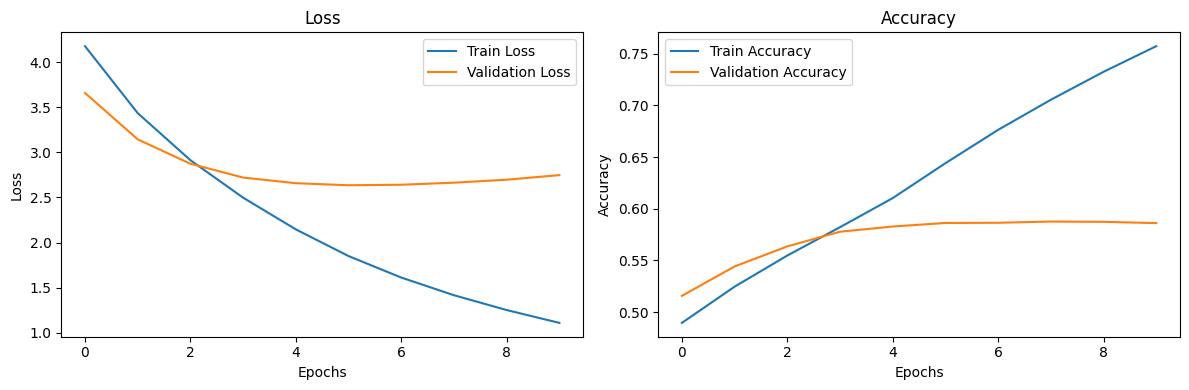

In [ ]:
# 모델 학습
history = model.fit(
    [train_text_padded, decoder_input_train],
    decoder_target_train.reshape(decoder_target_train.shape[0], decoder_target_train.shape[1], 1),
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(
        [val_text_padded, decoder_input_val],
        decoder_target_val.reshape(decoder_target_val.shape[0], decoder_target_val.shape[1], 1)
    )
)

# 학습 과정 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# 5. 인퍼런스 모델 구현 및 모델 테스트

In [ ]:
# 추론 모델 구현
# 1. 인코더 추론 모델
encoder_model = Model(encoder_inputs, [encoder_outputs, state_h, state_c])

# 2. 디코더 추론 모델을 위한 입력들
decoder_state_input_h = Input(shape=(lstm_units,))
decoder_state_input_c = Input(shape=(lstm_units,))
encoder_outputs_input = Input(shape=(max_text_len, lstm_units))

# 디코더 임베딩 레이어 재사용
dec_emb2 = dec_emb  # 이미 학습된 임베딩 레이어

# 디코더 LSTM 레이어 재사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(
    dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c]
)

# 어텐션 레이어 적용
attention_context = attention([decoder_outputs2, encoder_outputs_input])

# 어텐션 컨텍스트와 디코더 출력 결합
decoder_combined_context2 = Concatenate()([attention_context, decoder_outputs2])

# 출력 레이어
decoder_outputs2 = TimeDistributed(Dense(headline_vocab_size, activation="softmax"))(decoder_combined_context2)

# 디코더 모델
decoder_model = Model(
    [decoder_inputs, encoder_outputs_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2, state_h2, state_c2]
)

# 예측 함수 정의
def decode_sequence(input_seq):
    # 인코더를 통해 입력 시퀀스 인코딩
    enc_outs, enc_h, enc_c = encoder_model.predict(input_seq, verbose=0)

    # 디코더 입력 초기화 (<start> 토큰으로 시작)
    target_seq = np.zeros((1, max_headline_len))
    target_seq[0, 0] = start_token

    # 출력 시퀀스를 저장할 리스트
    decoded_tokens = []

    # 디코딩 루프
    for i in range(max_headline_len - 1):
        # 현재 상태에서 출력 토큰 예측
        output_tokens, h, c = decoder_model.predict(
            [target_seq, enc_outs, enc_h, enc_c],
            verbose=0
        )

        # 다음 토큰 예측 (가장 확률이 높은 토큰)
        sampled_token_index = np.argmax(output_tokens[0, 0, :])

        # <end> 토큰이나 패딩이면 종료
        if sampled_token_index == end_token or sampled_token_index == 0:
            break

        # 토큰 저장
        decoded_tokens.append(sampled_token_index)

        # 다음 타임스텝을 위해 타겟 시퀀스와 상태 업데이트
        target_seq = np.zeros((1, max_headline_len))
        target_seq[0, 0] = sampled_token_index
        enc_h, enc_c = h, c

    return decoded_tokens

# 토큰 시퀀스를 텍스트로 변환하는 함수
def seq_to_text(seq, tokenizer):
    index_to_word = {v: k for k, v in tokenizer.word_index.items()}
    return ' '.join([index_to_word.get(i, '') for i in seq])

# 테스트 데이터로 모델 평가
test_samples = min(10, len(test_text_padded))  # 테스트 샘플 수 제한
for i in range(test_samples):
    input_seq = test_text_padded[i:i+1]
    decoded_tokens = decode_sequence(input_seq)

    predicted_headline = seq_to_text(decoded_tokens, headline_tokenizer)
    actual_headline = seq_to_text(test_headline_seqs[i], headline_tokenizer)
    original_text = test_texts[i][:200] + "..."  # 원본 텍스트의 일부만 표시

    print(f"\n샘플 {i+1}:")
    print(f"원본 텍스트: {original_text}")
    print(f"실제 헤드라인: {actual_headline}")
    print(f"예측 헤드라인: {predicted_headline}")


샘플 1:
원본 텍스트: former south korean dentist seunggun lee mobile payments app toss raised million funding eight failed apps since earlier lee used work dentist hospital arm samsung group quit job found mobile payments...
실제 헤드라인: ex dentist new mobile app gets mn after failed apps
예측 헤드라인: ian nortje kritika kritika wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless

샘플 2:
원본 텍스트: lg testing two robot prototypes provide assistance travellers clean floors respectively south korea largest airport incheon international airport guiding robot speak korean english chinese japanese sc...
실제 헤드라인: lg tests robots to guide passengers in airport clean trash
예측 헤드라인: premonition traitor sq despacito sq traitor sq ayyasamy sq sq megapixel traitor vulnerable vulnerable vulnerable vulnerable vulnerable

샘플 3:
원본 텍스트: reacting chilli powder attack tuesday delhi cm arvind kejriwal said opposition trying get kille

# 6. 모델 성능 평가

In [ ]:
!pip install rouge

from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge

# Rouge 패키지 설치가 필요한 경우
!pip install rouge

nltk.download('wordnet')
rouge = Rouge()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



모델 성능 평가 (테스트 샘플 100개):
평균 BLEU 점수: 0.0000
평균 ROUGE-1 점수: 0.0000
평균 ROUGE-2 점수: 0.0000
평균 ROUGE-L 점수: 0.0000
모델이 저장되었습니다.


In [ ]:
def calculate_metrics(reference, hypothesis):
    # BLEU 점수 계산
    reference_tokens = [reference.split()]
    hypothesis_tokens = hypothesis.split()

    # hypothesis가 비어있는 경우 처리
    if not hypothesis_tokens:
        return {'bleu': 0, 'rouge-1': 0, 'rouge-2': 0, 'rouge-l': 0}

    bleu_score = sentence_bleu(reference_tokens, hypothesis_tokens)

    # ROUGE 점수 계산
    try:
        # hypothesis나 reference가 비어있으면 오류 발생할 수 있음
        if not hypothesis or not reference:
            return {'bleu': 0, 'rouge-1': 0, 'rouge-2': 0, 'rouge-l': 0}

        rouge_scores = rouge.get_scores(hypothesis, reference)[0]
        return {
            'bleu': bleu_score,
            'rouge-1': rouge_scores['rouge-1']['f'],
            'rouge-2': rouge_scores['rouge-2']['f'],
            'rouge-l': rouge_scores['rouge-l']['f']
        }
    except Exception as e:
        print(f"ROUGE 계산 중 오류 발생: {e}")
        # ROUGE 계산 실패 시
        return {
            'bleu': bleu_score,
            'rouge-1': 0,
            'rouge-2': 0,
            'rouge-l': 0
        }


bleu_scores = []
rouge1_scores = []
rouge2_scores = []
rougel_scores = []

test_samples = min(100, len(test_text_padded))

for i in range(test_samples):
    input_seq = test_text_padded[i:i+1]
    decoded_tokens = decode_sequence(input_seq)

    predicted_headline = seq_to_text(decoded_tokens, headline_tokenizer)
    actual_headline = seq_to_text(test_headline_seqs[i], headline_tokenizer)

    # 디버깅 출력
    if i < 5:  # 처음 5개 샘플만 출력
        print(f"\n샘플 {i+1}:")
        print(f"실제: '{actual_headline}'")
        print(f"예측: '{predicted_headline}'")

    # 빈 예측이면 건너뜀
    if not predicted_headline or not actual_headline:
        print(f"샘플 {i+1}: 빈 문자열 감지됨, 건너뜀")
        continue

    try:
        # ROUGE 점수 계산
        rouge_scores = rouge.get_scores(predicted_headline, actual_headline)[0]

        # BLEU 점수 계산
        reference_tokens = [actual_headline.split()]
        hypothesis_tokens = predicted_headline.split()
        bleu_score = sentence_bleu(reference_tokens, hypothesis_tokens)

        bleu_scores.append(bleu_score)
        rouge1_scores.append(rouge_scores['rouge-1']['f'])
        rouge2_scores.append(rouge_scores['rouge-2']['f'])
        rougel_scores.append(rouge_scores['rouge-l']['f'])

        if i < 5:  # 처음 5개 샘플의 점수 출력
            print(f"BLEU: {bleu_score:.4f}")
            print(f"ROUGE-1: {rouge_scores['rouge-1']['f']:.4f}")
    except Exception as e:
        print(f"샘플 {i+1} 점수 계산 오류: {e}")

# 메트릭 출력
if bleu_scores:
    avg_bleu = np.mean(bleu_scores)
    avg_rouge1 = np.mean(rouge1_scores)
    avg_rouge2 = np.mean(rouge2_scores)
    avg_rougel = np.mean(rougel_scores)

    print(f"\n모델 성능 평가 (유효 샘플 {len(bleu_scores)}개):")
    print(f"평균 BLEU 점수: {avg_bleu:.4f}")
    print(f"평균 ROUGE-1 점수: {avg_rouge1:.4f}")
    print(f"평균 ROUGE-2 점수: {avg_rouge2:.4f}")
    print(f"평균 ROUGE-L 점수: {avg_rougel:.4f}")
else:
    print("\n유효한 평가 샘플이 없습니다.")


샘플 1:
실제: 'ex dentist new mobile app gets mn after failed apps'
예측: 'ian nortje kritika kritika wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless wicketless'
BLEU: 0.0000
ROUGE-1: 0.0000

샘플 2:
실제: 'lg tests robots to guide passengers in airport clean trash'
예측: 'premonition traitor sq despacito sq traitor sq ayyasamy sq sq megapixel traitor vulnerable vulnerable vulnerable vulnerable vulnerable'
BLEU: 0.0000
ROUGE-1: 0.0000

샘플 3:
실제: 'opposition is trying to kill me delhi cm on chilli powder attack'
예측: 'vital emissions defender invictus tnt emissions tarantino tarantino tarantino tarantino tarantino tarantino tarantino tarantino tarantino tarantino tarantino'
BLEU: 0.0000
ROUGE-1: 0.0000

샘플 4:
실제: 'policeman touches up minister feet for his car'
예측: 'dowry size size size emiratis talks talks cheats barmy barmy barmy barmy barmy barmy barmy barmy barmy'
BLEU: 0.0000
ROUGE-1: 0.0000

샘플 5:
실제: 'i would

# 회고

-배운점: 개인적으로 LLM이 가장 어렵다고 생각했는데 실제로 동작하는 과정을 수행해보니 좋았다.

- 아쉬운 점: 학습 시간이 오래걸려 다양한 시도들을 못해본 것이 아쉽다.

- 느낀 점: LLM에 코드가 어려워서 차근차근 다시 공부가 필요할 것 같다.

- 어려웠던 점: 개인적으로 로컬에서 시도를 해보려고 했는데 버전, GPU 사용 등 문제가 너무 많아서 힘들었다.